## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [22]:
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 25

# Prepare Training Data
1. Descárgate el dataset
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [3]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\data\\PROF_train\\train\\"
TEST_PATH = ROOT_PATH + "\\data\\PROF_test1\\test1\\"

In [23]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [5]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [47]:
from sklearn.utils import shuffle
for vez in range(10000):
    df = shuffle(df)

In [48]:
df

,filename,category
94,cat.10081.jpg,cat
2083,cat.11872.jpg,cat
22433,dog.7689.jpg,dog
6103,cat.4240.jpg,cat
6507,cat.4604.jpg,cat
...,...,...
16546,dog.239.jpg,dog
15705,dog.1632.jpg,dog
19045,dog.4639.jpg,dog
9532,cat.7327.jpg,cat


### See Total In count

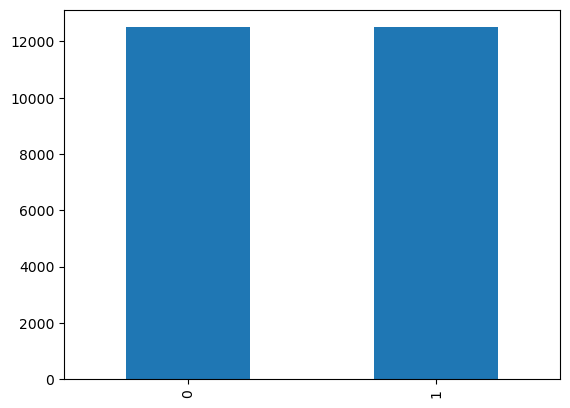

In [8]:
df['category'].value_counts().plot.bar();

# See sample image

(86, 167, 3)
255


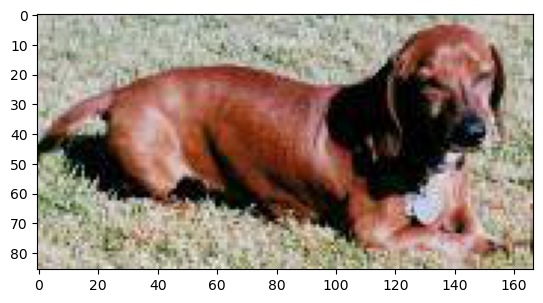

In [9]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [10]:
image

array([[[188, 188, 180],
        [181, 181, 173],
        [203, 204, 196],
        ...,
        [154, 154, 142],
        [173, 175, 162],
        [181, 185, 171]],

       [[202, 202, 194],
        [195, 195, 187],
        [202, 203, 195],
        ...,
        [164, 165, 151],
        [184, 186, 172],
        [190, 194, 179]],

       [[201, 201, 191],
        [196, 196, 186],
        [186, 188, 177],
        ...,
        [167, 168, 154],
        [184, 186, 172],
        [182, 186, 171]],

       ...,

       [[193, 185, 162],
        [190, 182, 161],
        [200, 193, 177],
        ...,
        [171, 168, 135],
        [197, 194, 161],
        [201, 198, 165]],

       [[142, 134, 111],
        [160, 152, 131],
        [216, 209, 193],
        ...,
        [129, 126,  95],
        [171, 168, 137],
        [170, 167, 136]],

       [[185, 177, 154],
        [164, 156, 135],
        [179, 172, 156],
        ...,
        [171, 167, 138],
        [187, 183, 154],
        [196, 192, 163]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (374, 500, 3)
Tamaño imagen reshape: (100, 100, 3)


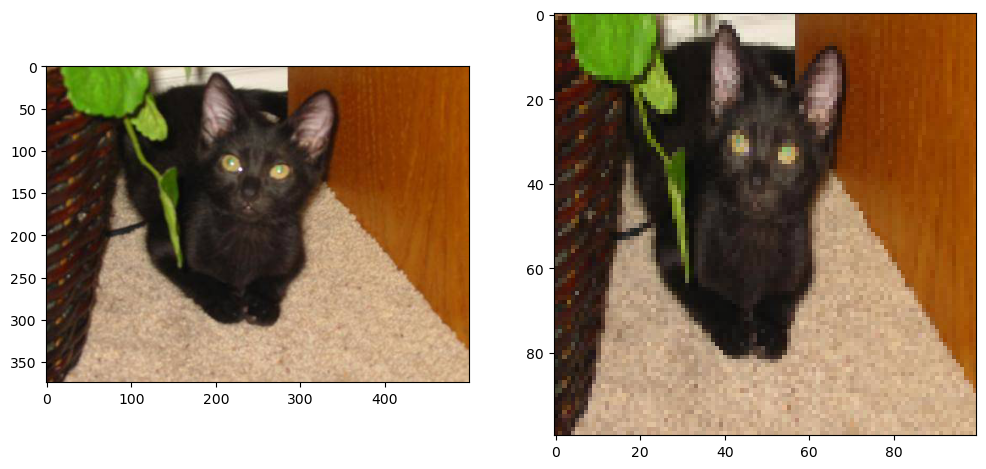

In [11]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Tamaño imagen original: (499, 332)


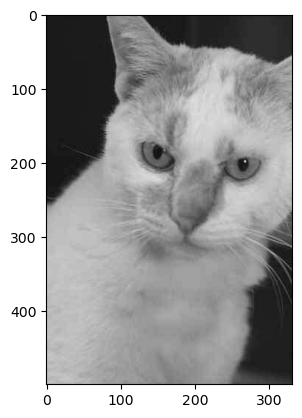

In [12]:
sample = random.choice(filenames)

image = cv2.imread(filename = TRAIN_PATH + sample, flags = cv2.IMREAD_GRAYSCALE)

print("Tamaño imagen original:", image.shape)
plt.imshow(image, cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [13]:
def read_data(path, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
        
        # Leer la imagen a color y aplicarle el resize
        image = imread(path + file)
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Guardo en X
        X.append(smallimage)
        
        category = file.split('.')[0]
        # Miro si es perro y gato para guardar en Y
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
        

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18750, 100, 100, 3)
(6250, 100, 100, 3)
(18750,)
(6250,)


(100, 100, 3)


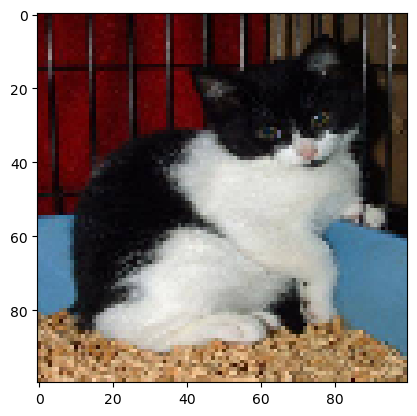

In [14]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [15]:
X_train[0]

array([[[ 79,   1,   2],
        [ 84,   2,  10],
        [ 45,   6,   7],
        ...,
        [ 73,  48,  18],
        [ 63,  50,  27],
        [ 68,  48,  27]],

       [[ 79,   4,   3],
        [ 77,   0,   5],
        [ 38,   3,   3],
        ...,
        [ 77,  52,  22],
        [ 67,  54,  31],
        [ 66,  46,  25]],

       [[ 71,   0,   0],
        [ 74,   0,   4],
        [ 46,  13,  12],
        ...,
        [ 78,  53,  23],
        [ 66,  54,  31],
        [ 70,  50,  29]],

       ...,

       [[144, 102,  71],
        [190, 145, 105],
        [213, 161, 112],
        ...,
        [210, 177, 133],
        [198, 163, 130],
        [121,  86,  61]],

       [[210, 168, 128],
        [ 91,  45,   9],
        [220, 171, 130],
        ...,
        [115,  87,  50],
        [120,  88,  50],
        [172, 138, 100]],

       [[125,  81,  34],
        [167, 122,  84],
        [156, 110,  76],
        ...,
        [111,  78,  39],
        [141, 114,  74],
        [159, 125,  72]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [16]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [18]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

Para cargar

In [4]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [31]:
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

layers = [
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    
]

model = keras.Sequential(layers)

model.compile(optimizer = RMSprop(learning_rate=1e-4),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])


In [29]:
#64*(3*3)*3+ 64

1792

In [ ]:
#128*(3*3)*3

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)      

# Callbacks
#### Early Stopping

In [33]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [34]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.keras")

# Fit the model

In [35]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2,
         verbose=1)

Epoch 1/25
469/469 [==============================] - 272s 576ms/step - loss: 0.6669 - accuracy: 0.5856 - val_loss: 0.6321 - val_accuracy: 0.6523
Epoch 2/25
469/469 [==============================] - 255s 544ms/step - loss: 0.6003 - accuracy: 0.6764 - val_loss: 0.5775 - val_accuracy: 0.6917
Epoch 3/25
469/469 [==============================] - 255s 545ms/step - loss: 0.5423 - accuracy: 0.7253 - val_loss: 0.5209 - val_accuracy: 0.7429
Epoch 4/25
469/469 [==============================] - 261s 557ms/step - loss: 0.5053 - accuracy: 0.7526 - val_loss: 0.4723 - val_accuracy: 0.7792
Epoch 5/25
469/469 [==============================] - 256s 547ms/step - loss: 0.4759 - accuracy: 0.7715 - val_loss: 0.4781 - val_accuracy: 0.7675
Epoch 6/25
469/469 [==============================] - 259s 551ms/step - loss: 0.4517 - accuracy: 0.7882 - val_loss: 0.4667 - val_accuracy: 0.7755
Epoch 7/25
469/469 [==============================] - 254s 541ms/step - loss: 0.4295 - accuracy: 0.7992 - val_loss: 0.4332 -

# Evaluate
Probemos los datos en el conjunto de test.

In [36]:
results = model.evaluate(X_test, y_test)
results

196/196 [==============================] - 27s 139ms/step - loss: 0.4024 - accuracy: 0.8466


[0.4023653268814087, 0.846560001373291]

In [37]:
model.predict(X_test).round(0)

196/196 [==============================] - 28s 143ms/step


array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

196/196 [==============================] - 28s 141ms/step


array([[2735,  449],
       [ 510, 2556]], dtype=int64)

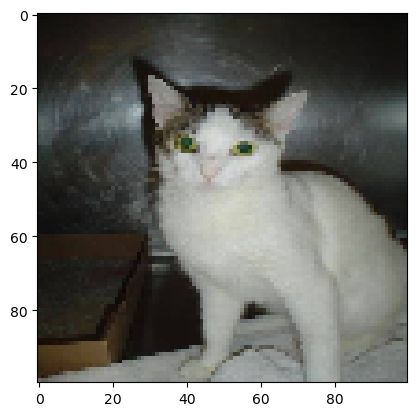

In [39]:
plt.imshow(X_test[-1]);

In [40]:
predictions = model.predict(X_test[-1:]).round(0)
predictions

1/1 [==============================] - 0s 60ms/step


array([[0.]], dtype=float32)

# Image data generator

In [57]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
94,cat.10081.jpg,cat
2083,cat.11872.jpg,cat
22433,dog.7689.jpg,dog
6103,cat.4240.jpg,cat
6507,cat.4604.jpg,cat


In [58]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

example_df = df.sample(n=1).reset_index(drop=True) # una foto
example_df

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = (128, 128)
)

Found 1 validated image filenames belonging to 1 classes.


In [59]:
example_df

,filename,category
0,cat.793.jpg,cat


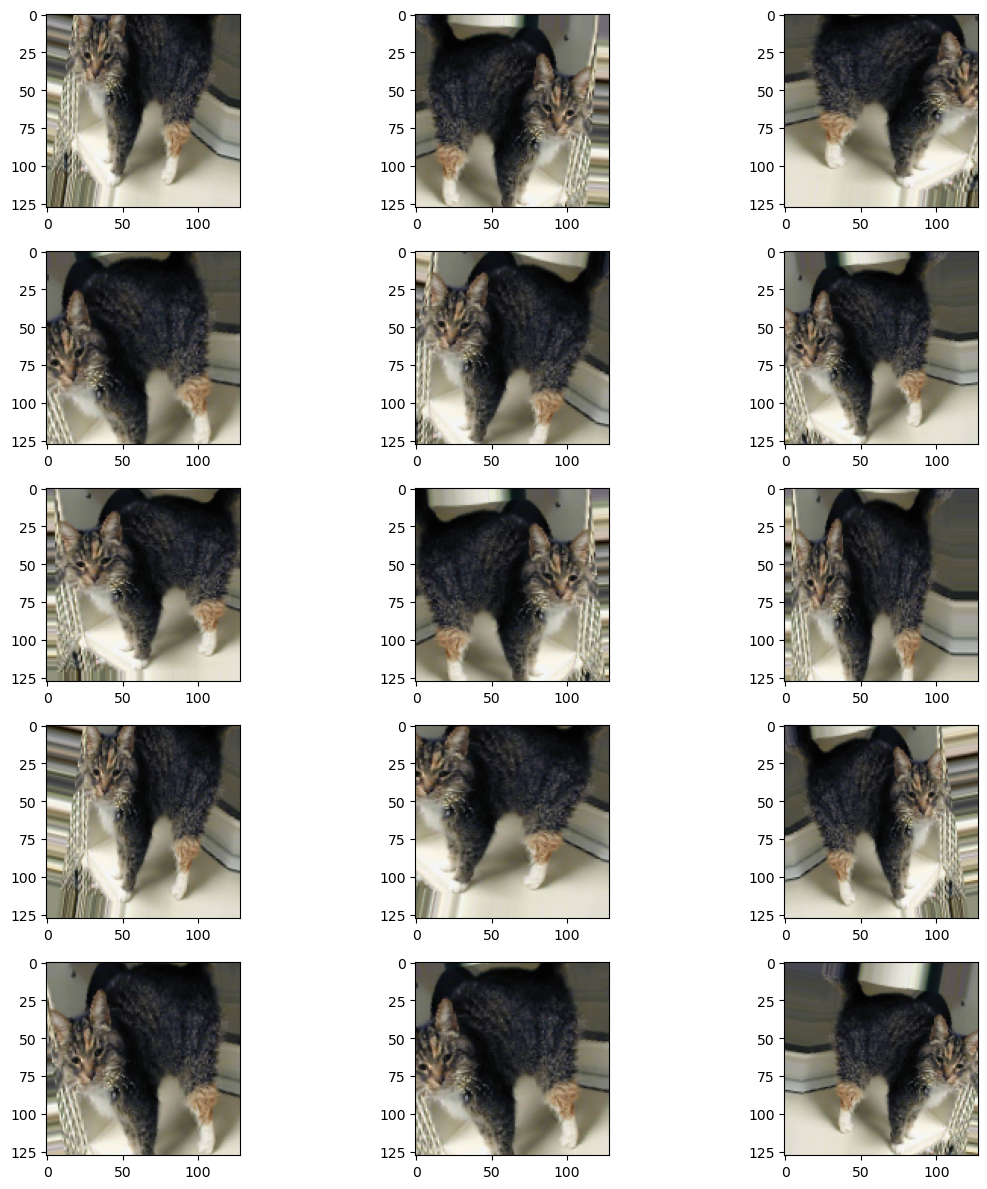

In [60]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Training Generator

In [62]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# 70% train, 30% test --> 0.7 *0.7 train, 0.3 * 0.7 val, 0.3 test
train_generator = train_datagen.flow_from_dataframe(
    df.iloc[:round(0.7*0.7*len(df)),:], 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 12250 validated image filenames belonging to 2 classes.


### Validation Generator

In [63]:

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df.iloc[round(0.7*0.7*len(df)):round(0.7*len(df)),:], 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 5250 validated image filenames belonging to 2 classes.


# Fit Model

In [64]:
model = keras.Sequential(layers)

model.compile(optimizer = RMSprop(learning_rate=1e-4),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [65]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = validation_generator
)

Epoch 1/25
383/383 [==============================] - 298s 773ms/step - loss: 0.4212 - accuracy: 0.8058 - val_loss: 0.2634 - val_accuracy: 0.8945
Epoch 2/25
383/383 [==============================] - 290s 758ms/step - loss: 0.3897 - accuracy: 0.8206 - val_loss: 0.2797 - val_accuracy: 0.8840
Epoch 3/25
383/383 [==============================] - 287s 748ms/step - loss: 0.3808 - accuracy: 0.8278 - val_loss: 0.2931 - val_accuracy: 0.8747
Epoch 4/25
383/383 [==============================] - 278s 726ms/step - loss: 0.3686 - accuracy: 0.8324 - val_loss: 0.3159 - val_accuracy: 0.8596
Epoch 5/25
383/383 [==============================] - 290s 756ms/step - loss: 0.3617 - accuracy: 0.8364 - val_loss: 0.2785 - val_accuracy: 0.8872
Epoch 6/25
383/383 [==============================] - 279s 729ms/step - loss: 0.3576 - accuracy: 0.8353 - val_loss: 0.2636 - val_accuracy: 0.8878
Epoch 7/25
383/383 [==============================] - 279s 729ms/step - loss: 0.3494 - accuracy: 0.8458 - val_loss: 0.3123 -

# Virtualize Training

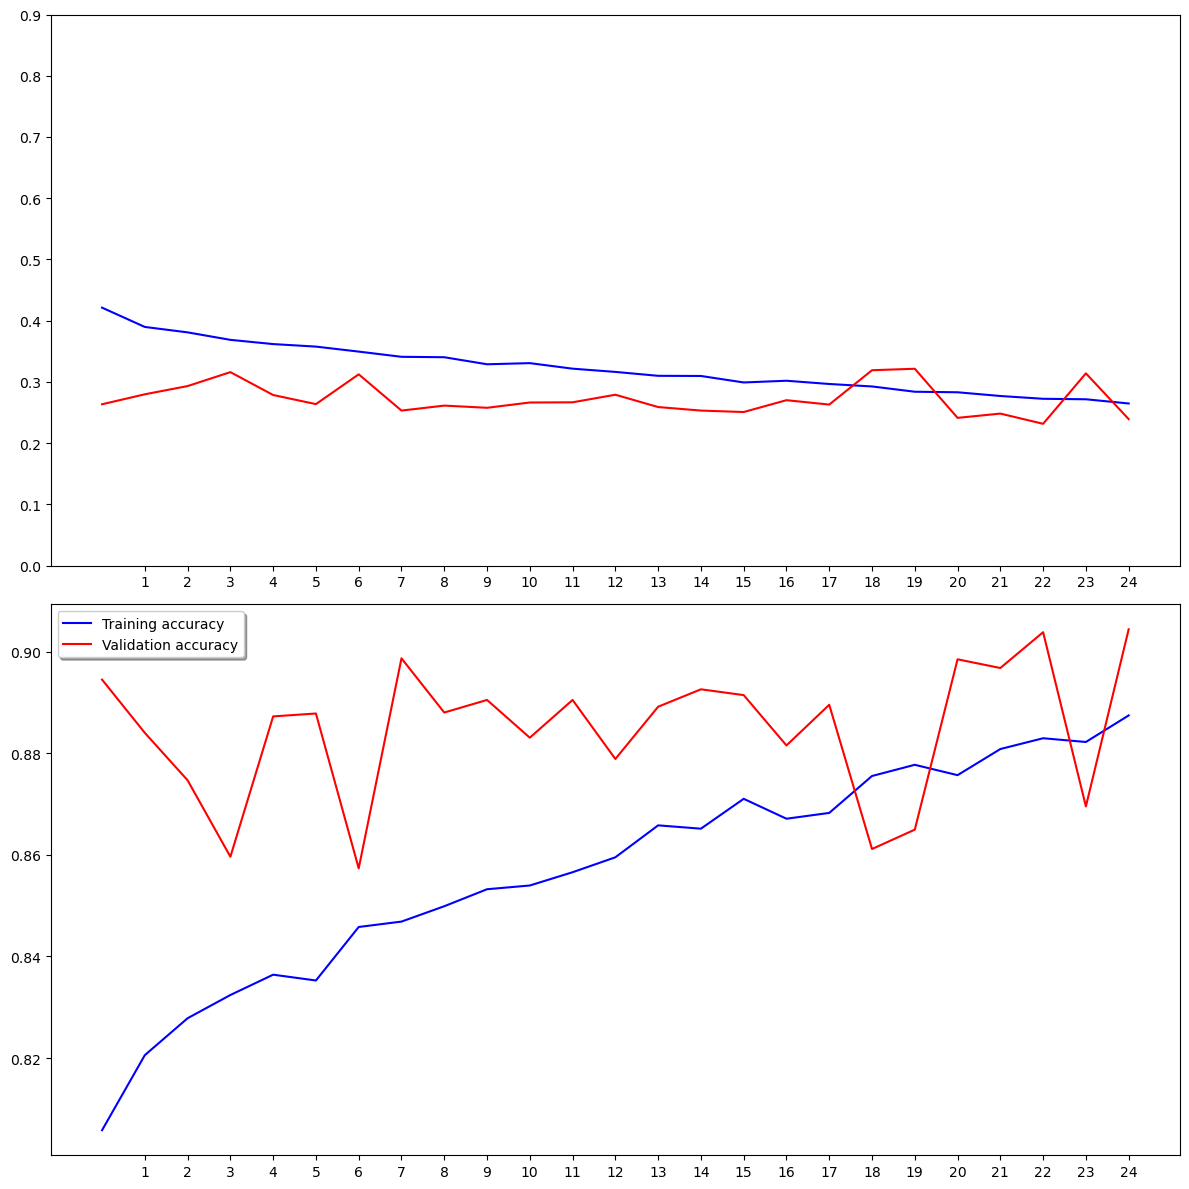

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [67]:
df.iloc[round(0.7*len(df)):,:]

,filename,category
5741,cat.3915.jpg,cat
19480,dog.503.jpg,dog
9448,cat.7251.jpg,cat
18560,dog.4201.jpg,dog
673,cat.10602.jpg,cat
...,...,...
16546,dog.239.jpg,dog
15705,dog.1632.jpg,dog
19045,dog.4639.jpg,dog
9532,cat.7327.jpg,cat


In [68]:
df_test = df.iloc[round(0.7*len(df)):,:]

In [ ]:
'dog.12189.jpg' in ['dog.12189.jpg']

In [73]:
def read_test_data(path, im_size, df_test):
    Xtest = []
    Ytest = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
            
        if file in df_test['filename'].tolist():
        
            # Leer la imagen a color y aplicarle el resize
            image = imread(path + file)
            smallimage = cv2.resize(image, (im_size, im_size))
        
        
            # Guardo en X
            Xtest.append(smallimage)
        
            category = file.split('.')[0]
            # Miro si es perro y gato para guardar en Y
            if category == 'dog':
                Ytest.append(1)
            else:
                Ytest.append(0)
        

    return np.array(Xtest), np.array(Ytest)
    

X_test2, y_test2 = read_test_data(TRAIN_PATH, IMAGE_WIDTH, df_test)

print(X_test2.shape)
print(y_test2.shape)

(7500, 100, 100, 3)
(7500,)


In [74]:
#testear con el último 30%

results2 = model.evaluate(X_test2, y_test2)
results2


235/235 [==============================] - 32s 135ms/step - loss: 63.9886 - accuracy: 0.8243


[63.98857498168945, 0.8242666721343994]

In [75]:
confusion_matrix(y_test2, model.predict(X_test2).round(0))

235/235 [==============================] - 34s 143ms/step


array([[2553, 1216],
       [ 102, 3629]], dtype=int64)

In [ ]:
# dije 0 gato pero era 1 perro, dije 102 veces gato pero era perro
# 1216 veces digo perro pero es gato

In [76]:
df.iloc[:round(0.7*0.7*len(df)),:].category.value_counts()  

dog    6139
cat    6111
Name: category, dtype: int64

In [77]:
df.iloc[round(0.7*0.7*len(df)):round(0.7*len(df)),:].category.value_counts()

dog    2630
cat    2620
Name: category, dtype: int64

In [78]:
df.iloc[round(0.7*len(df)):,:].category.value_counts()

cat    3769
dog    3731
Name: category, dtype: int64